In [1]:
import numpy as np
import networkx as nx
from karateclub.node_embedding import Node2Vec
from scipy.spatial.distance import cosine
np.random.seed(42)

Number of nodes: 34
Number of edges: 78
Nodes: [(0, {'club': 'Mr. Hi'}), (1, {'club': 'Mr. Hi'}), (2, {'club': 'Mr. Hi'}), (3, {'club': 'Mr. Hi'}), (4, {'club': 'Mr. Hi'}), (5, {'club': 'Mr. Hi'}), (6, {'club': 'Mr. Hi'}), (7, {'club': 'Mr. Hi'}), (8, {'club': 'Mr. Hi'}), (9, {'club': 'Officer'}), (10, {'club': 'Mr. Hi'}), (11, {'club': 'Mr. Hi'}), (12, {'club': 'Mr. Hi'}), (13, {'club': 'Mr. Hi'}), (14, {'club': 'Officer'}), (15, {'club': 'Officer'}), (16, {'club': 'Mr. Hi'}), (17, {'club': 'Mr. Hi'}), (18, {'club': 'Officer'}), (19, {'club': 'Mr. Hi'}), (20, {'club': 'Officer'}), (21, {'club': 'Mr. Hi'}), (22, {'club': 'Officer'}), (23, {'club': 'Officer'}), (24, {'club': 'Officer'}), (25, {'club': 'Officer'}), (26, {'club': 'Officer'}), (27, {'club': 'Officer'}), (28, {'club': 'Officer'}), (29, {'club': 'Officer'}), (30, {'club': 'Officer'}), (31, {'club': 'Officer'}), (32, {'club': 'Officer'}), (33, {'club': 'Officer'})]

Edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 

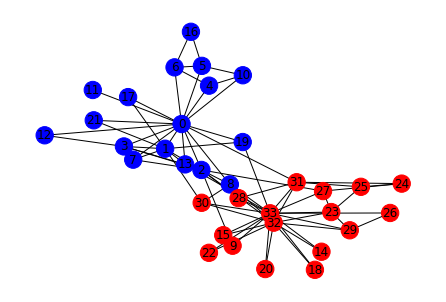

In [2]:
G = nx.karate_club_graph()
colormap = ["blue" if data["club"] == "Mr. Hi" else "red" for _, data in G.nodes(data=True)]
nx.draw(G, with_labels=True, node_color=colormap)
print("Number of nodes:", G.order())
print("Number of edges:", G.size())
print("Nodes:", G.nodes(data=True), end="\n\n")
print("Edges:", G.edges,end="\n\n")

# Node Embeddings

<b> Recap </b>

Previously we discussed traditional feature based methods for graph ML, where given a graph G = (V,E) we wanted to extract node, link and graph-level features and learn a model (svm, logistic regressor, etc.) that maps features to labels.

Input Graph -> Feature Engineering -> Learning Algorithm -> Prediction

<b> Now </b>

With <b>Representation Learning</b> we automatically learn the features, without needing to manually construct the features as we did before (feature engineering). 

<b> Goal </b>

Efficient task-independent feature learning for machine learning with graphs

## Why Embeddings?

<b>Task:</b> map nodes into an embedding space

* Similarity of embeddings between nodes indicates their similarity in the network.
* Encode network information
* Potentially used for many downstream prediction tasks such as node classification, link prediction, graph classification, anomalous node detection, clustering, etc.

## Embedding Nodes

<b>Goal:</b> Find an encoder function such that, when nodes u and v are encoded to the embedding space, the following assumption is true:
the similarity between nodes u and v in the network is close to the similarity of the embedding representation of u and v in embedding space.

similarity(u,v) ~ z_v.T @ z_u

1. Encoder maps nodes to embeddings: Encoder(u) -> z_u.
2. Define a similarity function for the original network.
3. Decoder maps from embeddings to the embedding similarity score: dot preduct.
4. Optimize the parameters such that similarity(u,v) ~ decoder(encoder(u), encoder(v)).

This is an <b>unsupervised</b> way of learning node embeddings so we do not use labels or features. Also, the embeddings are task independent, because they are not trained for a specific task.

## "Shallow" Encoding

Simplest encoding approach: encoder is just an embedding-lookup. Each node is assigned a unique embedding vector, so we optimize the embedding of each node using one of many methods: DeepWalk, node2vec. Each optimization method defines its own similarity measure.

Encoder(v) = z_v = Z . v

Z in R ^ (d x |V|) - Z is a matrix with each column represents a node embedding (what we learn/optimize).

v in I ^ |V| - v is an indicator vector, all zeroes except a onde in column indicating node Vb

In [3]:
# 100 nodes with embedding size of 128
Z = np.random.randn(128, 100) #  this needs to be optimized somehow. In this example its a random matrix

# 100 entries for the indicator vetor, one for each node
v = np.zeros(100)
v[0] = 1

z = Z @ v

print("Dimensions -- Z:", Z.shape, "v:", v.shape, "z:", z.shape)
print("z is equal to the first column of Z:", (Z @ v == Z[:,0]).all())

Dimensions -- Z: (128, 100) v: (100,) z: (128,)
z is equal to the first column of Z: True


# Random-Walk Approaches for Node Embeddings

<b>Random Walk</b>

Given a graph G = (V, E) and a starting point v in V, we select a neighbor u in N(v) at random and move to u. Then we repeat this process for a random node z in N(u) and so on, creating a random sequence of nodes visited from a starting point.

Note: the same node can be visited multiple times in a random walk.

Provides:

1. Expressivity: flexible stochastic defintion of node similarity that incorporates both local and higher-order neighborhood information. Intuition: if random walk starting from node u visits v with high probability, u and v are similar (high-order multi-hop information).
2. Efficiency: do not need to consider all node pairs when training. Only need to consider pairs that co-occur on random walks. 

In [4]:
def random_walk(G, starting_node, length):
    node = starting_node
    walk = [node]
    for _ in range(length):
        neighbors = list(G.neighbors(node))
        idx = np.random.choice(len(neighbors), replace=False)
        node = neighbors[idx]
        walk.append(node)

    return walk

'0 -> 8 -> 30 -> 33 -> 31 -> 28'

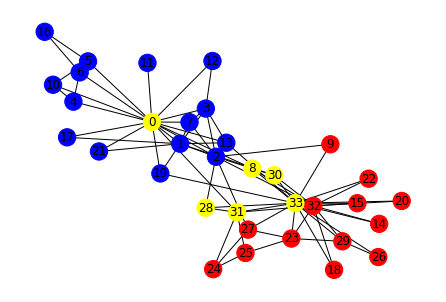

In [5]:
walk = random_walk(G, starting_node=0, length=5)

# plot
path_colormap = ["yellow" if node in walk else default_color for node, default_color in zip(G.nodes(), colormap)]
nx.draw(G, with_labels=True, node_color=path_colormap)

" -> ".join(str(node) for node in walk)


<b>Random-Walk Embeddings</b>

Goal: learn embeddings Z such that z_u.T @ z_v ~ probability that u and v co-occur on a random walk over the graph. In other words, nodes that appear togheter frequently in many random walks should have similar embedding representations.

1. Estimate the probability of visiting node v on a random walk starting from node u: P(v|u)
2. Optimize embeddings to encode these random walk statistics: cosine theta between z_u and z_v is proportional to P(v|u). This step is described in details below.

<b>Random Walk Optimization</b>

1. Run short fixed-length random walks starting from each node u in the graph.
2. For each node u collect N_r(u), the multiset of nodes visited on random walks starting from u. N_r(u) can repeat elements since nodes can be visited multiple times on random walks.
3. Optimize embeddings according to: given node u, predict its neighbors N_r(u) using z_u.

max (for each u in V -> log P(N_r(u)|z_u)) -- maximum likelihood objective.

Equivalently, we can write:

> L = for each u in V and for each v in N_r(u) -> -log(P(v|z_u))

Optimize embeddings z_u to maximize the likelihood of random walk co-occurrences.

P(v|z_u) is the softmax of the dot product between z_u and z_v. P(v|z_u) = softmax(z_u.T @ z_v). \*

Finally: find embeddings z_u that minimize L by applying stochastic gradient descent:

* initilize z_u randomly for each u in V.
* Iterate until converge:
    * For all nodes u, compute the derivative of z_u w.r.t L.
    * For all nodes u, make a step towards the diretion of the derivative: z_u <- z_u - learning_rate * derivative of z_u w.r.t L.

<b> * Consideration: Negative Sampling </b>

Softmax is defined as exp(z_u.T @ z_v)/(sum for each n in V -> exp(z_u.T @ z_n)). This is O(|V|^2) because of the denominator that iterates over every node in V. To reduce this computation, we use negative sampling.

Negative sampling is a technique that samples k nodes at random (usually k = 5 up to k = 20 ) instead of using all nodes in V. The k nodes are not sellected with uniform probability, but with a biased probability. The highest the degree of a node, the bigger the probability of it being sampled.

softmax(z_u.T @ z_v) ~ log(sigmoid(z_u.T @ z_v)) - sum from i to k -> log (sigmoid(z_u.T @ z_i))



### Node2Vec

<b>Biased Walks</b>

* Use flexible, biased random walks that can trade off between local and global views of the network. Interpolate breadth-first search (BFS) to explore the local (micro-view) structure near a node and depth-first search (DFS) to explore the global (macro-view) structure near a node.
* Set a fixed walk length.
* Two hyperparameters:
    * "Return" p: constant value that represents the likelihood to return to the previous node. The smaller p is, the highest the probability to return to the previous node.
    * "In-out" q: intuitively, q is the "ratio" of BFS vs. DFS. Constant value that represents the likelihood to make a BFS or DFS step whem moving to another node. The smaller q is, the highest the probability to use a DFS method.
* At each step, the node has a probability distribution considering each scenario:
    * Return to the previous node with probability 1/p.
    * Stay in the 1-hop distance from the previous node (BFS) with constrant probability.
    * Navigate further from the previous node (DFS) with 1/q probability.
* This probability distribution for each possibility is then normalized to sum to one.
* After l steps, N_r(u) are the nodes bisited by the biased walk of length l.

<b>Node2Vec Algorithm</b>

1. Compute random walk probabilities.
2. Simulate r random walks of length l starting from each node u.
3. Optimize the node2vec objective using stochastic gradient descent.

* Linear-time complexity
* All three steps are individually parallelizable

In [6]:
n2v = Node2Vec(walk_number=10, walk_length=5, p=1.0, q=1.0, dimensions=128)
n2v.fit(G)
Z = n2v.get_embedding()
print("Embeddings:\n", Z, "\n\nZ Shape:", Z.shape)

Embeddings:
 [[-6.1309431e-03  4.4923713e-03  2.8222071e-03 ...  1.4523641e-03
  -6.6852723e-03  4.7208481e-03]
 [ 2.8384095e-03  6.8760929e-03  5.8848979e-03 ...  4.6388456e-03
   1.5763207e-03 -2.3730827e-05]
 [ 5.5479663e-03  5.4084929e-03  7.6215682e-03 ... -2.7619656e-03
   4.4345260e-03  7.4818917e-03]
 ...
 [-5.6087659e-03 -2.3228680e-03  2.3696199e-03 ...  7.9064379e-03
   3.3976892e-03  2.1286192e-03]
 [ 3.3650920e-03 -6.4177508e-03 -4.7627049e-03 ...  7.7405083e-03
   7.0426972e-03 -3.0673544e-03]
 [ 9.1897481e-04  1.2969001e-03  1.1895263e-03 ... -1.4013723e-03
   2.5670580e-03 -5.4048258e-03]] 

Z Shape: (34, 128)


In [7]:
distances = np.zeros((Z.shape[0], Z.shape[0]))
for i, u in enumerate(Z):
    for j, v in enumerate(Z):
        if (u != v).all():
            d = cosine(u, v)
            distances[i,j] = d

print("Distance Matrix:\n",distances)

closets_pairs = {}
for i, node in enumerate(distances):
    valid_idxs = np.where(node > 0)[0]
    closest_node = valid_idxs[np.argmin(node[valid_idxs])]
    closets_pairs[i] = closest_node

print("\nClosest pairs:\n", closets_pairs)

Distance Matrix:
 [[0.         1.12696698 0.97506407 ... 0.94918665 0.98398876 1.09581439]
 [1.12696698 0.         0.91117263 ... 0.97844445 1.10379466 1.16000153]
 [0.97506407 0.91117263 0.         ... 0.99245669 1.00054894 0.84633151]
 ...
 [0.94918665 0.97844445 0.99245669 ... 0.         0.96540174 0.90389856]
 [0.98398876 1.10379466 1.00054894 ... 0.96540174 0.         0.85394418]
 [1.09581439 1.16000153 0.84633151 ... 0.90389856 0.85394418 0.        ]]

Closest pairs:
 {0: 30, 1: 22, 2: 22, 3: 22, 4: 15, 5: 24, 6: 15, 7: 8, 8: 19, 9: 10, 10: 9, 11: 22, 12: 15, 13: 21, 14: 28, 15: 6, 16: 18, 17: 5, 18: 16, 19: 8, 20: 23, 21: 13, 22: 3, 23: 20, 24: 5, 25: 23, 26: 32, 27: 32, 28: 14, 29: 20, 30: 26, 31: 22, 32: 27, 33: 23}
